# Imports & data cleaning

About the data: This dataset contains every wholesale purchase of liquor in the State of Iowa by retailers for sale to individuals since January 1, 2012. The State of Iowa controls the wholesale distribution of liquor intended for retail sale, which means this dataset offers a complete view of retail liquor sales in the entire state. The dataset contains every wholesale order of liquor by all grocery stores, liquor stores, convenience stores, etc., with details about the store and location, the exact liquor brand and size, and the number of bottles ordered.

More information plus data dictionary: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.cloud import bigquery
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
import math

In [25]:
#print(plt.style.available)
plt.style.use("seaborn-deep")
#plt.rcParams # accessing the parameter settings for matplotlib

In [5]:
import multiprocessing as mp

In [83]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [29]:
#placing an 'r' before a normal string converts it to a raw string and resolves the unicode error python throws
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"C:\Users\Owner\Desktop\Missouri\STATS 7510\bigquery20190823.json"   

In [30]:
client = bigquery.Client()

In [31]:
client

In [56]:
#for computation purposes, the query is limited to 2018 and 2019 data, which is updated monthly
query = """
SELECT 
  *
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date > '2018-01-01'
"""

In [57]:
result = client.query(query).to_dataframe()

In [58]:
result.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [62]:
result.to_csv('liquor_df_original.csv')

## Basic data exploration & manipulation

In [304]:
work['lat']=work['store_location'].str[7:17]

In [305]:
work['store_location']=(work['store_location'].str[7:]).str[:-1]

In [306]:
lat_long = work.store_location.str.split(expand=True)
lat_long.rename(columns={0: 'lat', 1: 'long'}, inplace=True)
work_2= work.merge(lat_long, how='left', left_index=True, right_index=True)
work_2.drop(columns=['Unnamed: 0', 'lat_x'], axis=1, inplace=True)
work_2.rename(columns={'lat_y': 'lat'}, inplace=True)

In [20]:
# college towns and liquor sales??
college_towns= ['Cedar Falls','Cedar Rapids','Des Moines','Ames','Iowa City','Davenport',
               'Grinnell','Decorah','Fairfield','Waverly'] #2019 ranking top 10 colleges in Iowa:https://www.4icu.org/us/iowa/

In [313]:
work_2['college_town']=np.where(work_2.city.isin(college_towns), 1, 0)

In [314]:
work_2.college_town.mean() # 27.6% of the order occurred in "College towns"

0.2904954459957797

# Descriptive Statistics
## Describing the customer


In [2]:
df = pd.read_csv("iowa_liquor.csv")

In [3]:
df['date'] = pd.to_datetime(df.date)

In [4]:
df = df.sort_values(by=['store_number', 'date'])

#### What are the most popular liquors by order volume?

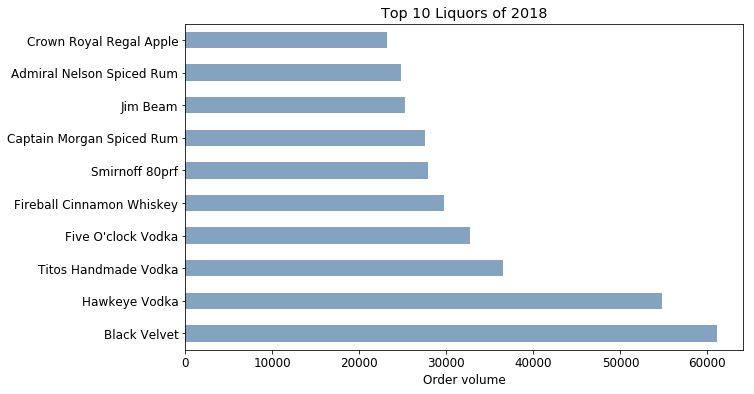

''

In [39]:
plt.figure(figsize=(10,6))

df.loc[(df.date >= '2018-01-01')
       & (df.date < '2019-01-01')].groupby("item_description").item_description.count().sort_values(ascending=False).head(10).plot.barh(color=(0.2, 0.4, 0.6, 0.6), label='All Towns')

plt.title("Top 10 Liquors of 2018")
plt.ylabel("")
plt.xlabel("Order volume")

plt.show()
;

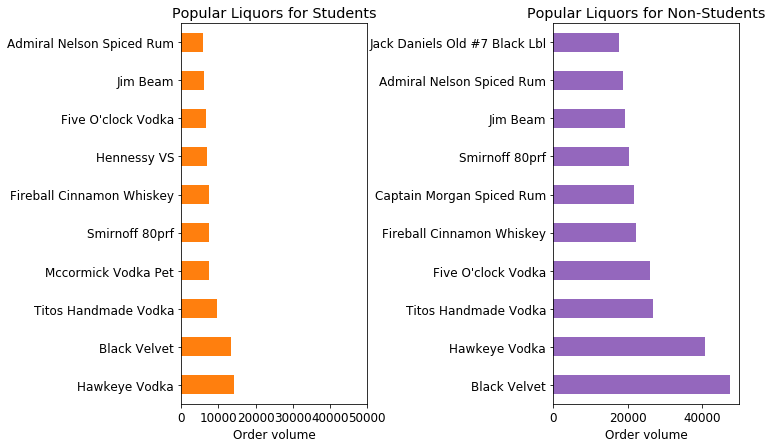

In [60]:
plt.figure(figsize=(10,7))
plt.subplots_adjust(wspace=1)

plt.subplot(1,2,1)
df.loc[(df.date >= '2018-01-01')
       & (df.date < '2019-01-01')
       & (df.college_town ==1)].groupby("item_description").item_description.count().sort_values(ascending=False).head(10).plot.barh(color=('tab:orange'), label='College Towns')

plt.title('Popular Liquors for Students')
plt.ylabel("", fontsize=8)
plt.xlim(0,50000)
plt.xlabel('Order volume')


plt.subplot(1,2,2)
df.loc[(df.date >= '2018-01-01')
       & (df.date < '2019-01-01')
       & (df.college_town ==0)].groupby("item_description").item_description.count().sort_values(ascending=False).head(10).plot.barh(color=('tab:purple'), label='Not College Towns')

plt.title("Popular Liquors for Non-Students")
plt.ylabel("", fontsize=8)
plt.xlabel("Order volume")


plt.show();


The top three favorites are consistent among all Iowans, regardless of student status. 

Note the Mccormick Vodka Pet ranking 4th for college students. PET packaging is recyclable materials intended to give a bottle a premium look, but also be eco-friendly.

#### What is each city's favorite liquor?

In [139]:
prod_names = pd.DataFrame(df.groupby(['city','item_description'])['item_description'].count())
# prod_names.rename(columns={'item_description':'count'}, inplace=True)
# prod_names.rename(columns={'item_description':'product'}, inplace=True)

In [117]:
city = pd.DataFrame(df.groupby(['city','item_description'])['item_description'].count().max(level=0))
city.rename(columns={'item_description': 'max'}, inplace=True)

In [149]:
#prod_names?? Returning to this later

## Orders over time

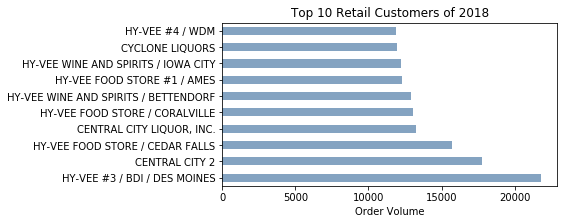

In [252]:
plt.figure(figsize=(6,3))

df.loc[(df.date>= '2018-01-01')
       & (df.date < '2019-01-01')].groupby('store_name').invoice_and_item_number.count().sort_values(ascending=False).head(10).plot.barh(color=(0.2, 0.4, 0.6, 0.6))

plt.title("Top 10 Retail Customers of 2018")
plt.ylabel("")
plt.xlabel("Order Volume")


plt.show();


#### Order frequency for the top 10

In [171]:
top10 = pd.DataFrame(df.loc[(df.date>= '2018-01-01')
       & (df.date < '2019-01-01')].groupby('store_name').invoice_and_item_number.count().sort_values(ascending=False).head(10))

In [174]:
top10=top10.reset_index()

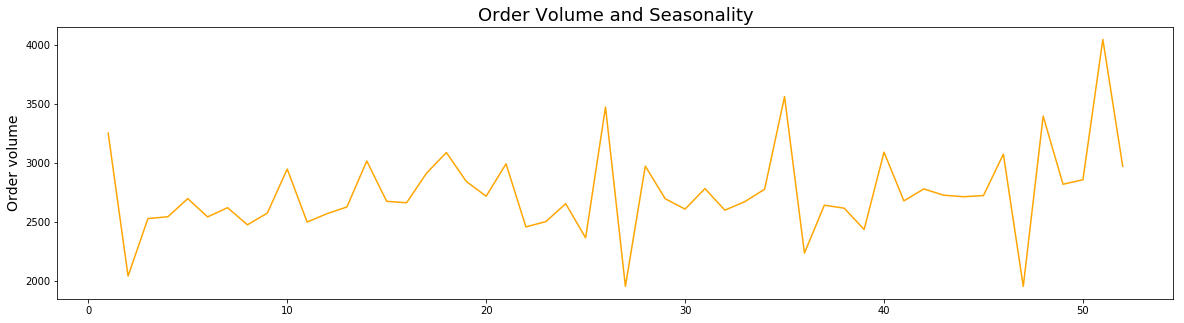

In [285]:
# item count per date
mask=list(top10.store_name)

plt.figure(figsize=(20,5))
df.loc[(df.store_name.isin(mask))
      & (df.date < '2019-01-01')].groupby(['week']).item_description.count().plot(color='orange')
# df.loc[(df.store_name.isin(mask))
#       & (df.date < '2019-01-01')].groupby(['month']).item_description.count().plot(color='blue')
# sample.loc[sample.item_description.isin(mask2)].groupby(['date']).item_description.count().plot(label='least popular')

plt.title("Order Volume and Seasonality", fontsize=18)
plt.xlabel('',fontsize=14)
plt.ylabel('Order volume', fontsize=14)

plt.show();

Observations: Smoothing orders to weeks and months, we see that there is drastic, but seemingly unpredictable changes in ordering habits for top retailers. The inconsistency could pose problems for vendors' supply chains.
    
Does this observation hold true across all the stores? 

In [259]:
annual_orders= pd.DataFrame(df.loc[(df.date>='2018-01-01')
                                  & (df.date < '2019-01-01')].groupby(['store_name','date']).item_description.count())

In [261]:
annual_orders = annual_orders.reset_index()

In [264]:
annual_orders.sort_values(by=['store_name','date'], inplace=True)

In [265]:
annual_orders['week']= annual_orders.sort_values(by=['store_name','date']).date.dt.week
annual_orders['month']= annual_orders.sort_values(by=['store_name','date']).date.dt.month

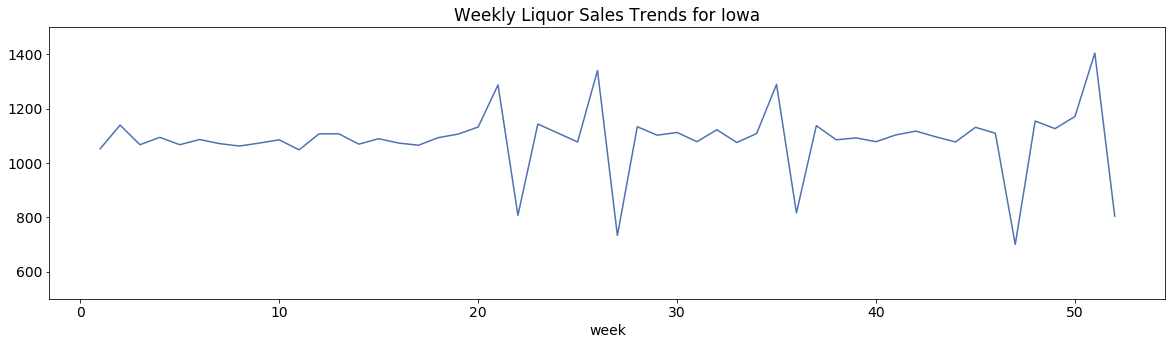

In [328]:
font = {'size': 14}
plt.rc('font', **font)
plt.figure(figsize=(20,5))

annual_orders.groupby('week').item_description.count().plot()
#annual_orders.loc[annual_orders.store_name.str.contains( 'HY-VEE')].groupby('month').item_description.count().plot(label='All Hy-Vee Stores')
# annual_orders.loc[annual_orders.store_name.str.contains('CENTRAL CITY 2', 'CENTRAL CITY LIQUOR, INC.')].groupby('month').item_description.count().plot(label='Central City Liquor')
# annual_orders.loc[annual_orders.store_name.str.contains('CYCLONE LIQUORS')].groupby('month').item_description.count().plot(label='Cyclone Liquors')

#plt.legend(loc=1)
plt.title("Weekly Liquor Sales Trends for Iowa")
plt.ylim(500,1500)
plt.show();

When scaled to all Iowa liquor retailers, the lack of pattern in ordering appears to hold true. 

### Examing order trends for vendors
#### Goal: Given a set of input variables, can we predict when a store will place an order? Can we predict the order items? Using this forecast will help gain supply chain efficiencies. 

In [303]:
top_vendors= pd.DataFrame(df.groupby(['vendor_name']).item_description.count().sort_values(ascending=False).head(21)).reset_index()

In [312]:
top_vendors # top 20 vendors by order volume in Iowa

,vendor_name,item_description
0,DIAGEO AMERICAS,626592
1,Jim Beam Brands,340016
2,LUXCO INC,306546
3,SAZERAC COMPANY INC,287443
4,PERNOD RICARD USA,218183
5,CONSTELLATION BRANDS INC,212792
6,SAZERAC NORTH AMERICA,177058
7,Heaven Hill Brands,156786
8,BACARDI USA INC,144444
9,PROXIMO,141779


In [ ]:
font = {'size': 14}
plt.rc('font', **font)
plt.figure(figsize=(20,5))

annual_orders.groupby(['vendor_name','week']).item_description.count().plot()
#annual_orders.loc[annual_orders.store_name.str.contains( 'HY-VEE')].groupby('month').item_description.count().plot(label='All Hy-Vee Stores')
# annual_orders.loc[annual_orders.store_name.str.contains('CENTRAL CITY 2', 'CENTRAL CITY LIQUOR, INC.')].groupby('month').item_description.count().plot(label='Central City Liquor')
# annual_orders.loc[annual_orders.store_name.str.contains('CYCLONE LIQUORS')].groupby('month').item_description.count().plot(label='Cyclone Liquors')

#plt.legend(loc=1)
plt.title("Weekly Liquor Sales Trends for Iowa")
plt.show();

In [318]:
vendor_orders = pd.DataFrame(df.loc[(df.date>='2018-01-01')
                                  & (df.date < '2019-01-01')].groupby(['vendor_name','date']).item_description.count()).reset_index()
vendor_orders['week'] = vendor_orders.date.dt.week
vendor_orders['month'] = vendor_orders.date.dt.month

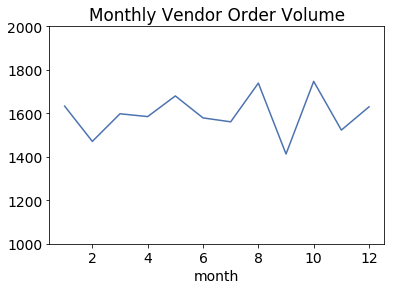

In [330]:
vendor_orders.groupby('month').item_description.count().plot()

plt.ylim(1000,2000)
plt.title('Monthly Vendor Order Volume');

The order volume in September appear much lower than August and October. Is it statistically lower?

In [325]:
vendor_orders.loc[vendor_orders.month == 8].item_description.describe()

count    1739.000000
mean      123.539965
std       266.127268
min         1.000000
25%         2.000000
50%         8.000000
75%       105.000000
max      2220.000000
Name: item_description, dtype: float64

In [326]:
vendor_orders.loc[vendor_orders.month == 9].item_description.describe()

count    1413.000000
mean      119.411890
std       255.137715
min         1.000000
25%         2.000000
50%         8.000000
75%       107.000000
max      1993.000000
Name: item_description, dtype: float64

- note zero difference in median

In [331]:
vendor_orders.head(10)

,vendor_name,date,item_description,week,month
0,3 BADGE CORPORATION,2018-02-09,3,6,2
1,3 BADGE CORPORATION,2018-02-15,2,7,2
2,3 BADGE CORPORATION,2018-02-21,2,8,2
3,3 BADGE CORPORATION,2018-03-05,1,10,3
4,3 BADGE CORPORATION,2018-03-27,1,13,3
5,3 BADGE CORPORATION,2018-03-29,1,13,3
6,3 BADGE CORPORATION,2018-04-30,2,18,4
7,3 BADGE CORPORATION,2018-05-14,2,20,5
8,3 BADGE CORPORATION,2018-06-25,1,26,6
9,3 BADGE CORPORATION,2018-07-09,1,28,7


### Paired t-test: Does August have significantly lower order volume that September?

In [362]:
sept = pd.DataFrame(vendor_orders.loc[vendor_orders.month == 9].groupby('vendor_name').item_description.sum()).reset_index()
aug = pd.DataFrame(vendor_orders.loc[vendor_orders.month == 8].groupby('vendor_name').item_description.sum()).reset_index()

In [363]:
compare = aug.merge(sept, how='inner', on='vendor_name')

len(sept), len(aug), len(compare)

(119, 124, 108)

In [370]:
# Paired t test only for vendors who appeared in both August and September
stats.ttest_rel(compare.item_description_x, compare.item_description_y)

Ttest_relResult(statistic=3.9839910164727628, pvalue=0.00012395162266141838)

Conclusion: a p-value of 0.0001 indicates that there is a significant decrease in liquor order volume for vendors in September compared to August. 
- What does this mean for forecasting order volume?

In [389]:
compare['difference'] = compare.item_description_x - compare.item_description_y
compare['diff_as_pct'] = -1*(compare.difference/compare.item_description_x)

In [390]:
compare.difference.describe()

count     108.000000
mean      426.787037
std      1113.280872
min       -33.000000
25%         2.000000
50%        13.000000
75%       146.750000
max      8277.000000
Name: difference, dtype: float64

In [385]:
compare.diff_as_pct.describe()

count    108.000000
mean       0.160112
std        0.370598
min       -1.200000
25%        0.072409
50%        0.214995
75%        0.339041
max        0.882353
Name: diff_as_pct, dtype: float64

''

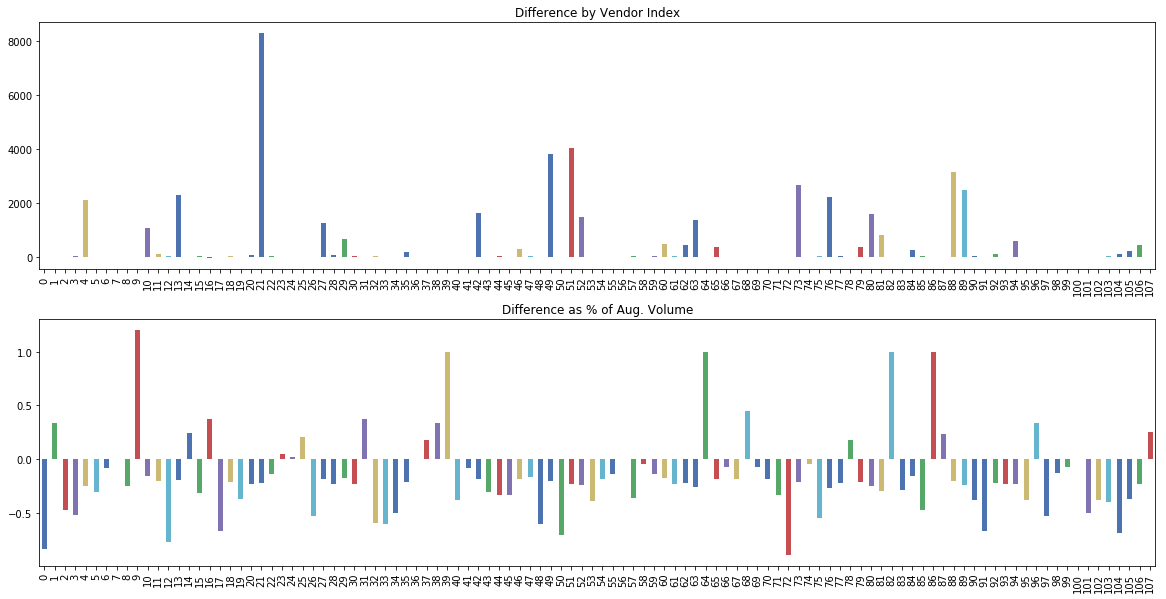

In [391]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
compare.difference.plot.bar()
plt.title('Difference by Vendor Index')

plt.subplot(2,1,2)
compare.diff_as_pct.plot.bar()
plt.title('Difference as % of Aug. Volume')
;

In [394]:
compare.iloc[9]

vendor_name           Best Case Wines LLC
item_description_x                      5
item_description_y                     11
difference                             -6
diff_as_pct                           1.2
Name: 9, dtype: object

In [395]:
compare.diff_as_pct.median()

-0.21499549268427987

### On average, vendors see a 16% descrease in order volume from August to September. Median = -21%

# Conclusions: 
### - Product preference/popularity is relatively stable across Iowa when delineating by "college town" as an age proxy
### - Monthly and weekly order volume by stores appears fairly irregular
### - This causes irregularity for vendors, giving reason to develop sophisticated forecasting methods for vendors' supply chains
